Question: Will adjusted closing price for Apple go up or down the next day?

In [8]:
import pandas as pd 
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [134]:
# aapl = yf.Ticker('AAPLE')
# date_from = str(dt.date.today() - dt.timedelta(days=1000))
# date_to = str(dt.date.today())

# print(f'Downloading Apple stock data from {date_from} to {date_to}.')
# apple = yf.download("AAPL", start=date_from, end=date_to)
apple = yf.Ticker("AAPL")
apple_hist = apple.history(period="max")

[*********************100%***********************]  1 of 1 completed


In [155]:
apple_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099584,0.100017,0.099584,0.099584,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094821,0.094821,0.094388,0.094388,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087893,0.087893,0.087461,0.087461,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089625,0.090058,0.089625,0.089625,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.092224,0.092657,0.092224,0.092224,73449600,0.0,0.0


In [157]:
# set up ground truth labels 
data=apple_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual Close'})
data['y'] = apple_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
apple_prev = apple_hist.copy()
apple_prev = apple_prev.shift(1)

predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data.join(apple_prev[predictors])
data.head()

,Actual Close,y,Open,High,Low,Close,Volume
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099584,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15 00:00:00-05:00,0.094388,0.0,0.099584,0.100017,0.099584,0.099584,469033600.0
1980-12-16 00:00:00-05:00,0.087461,0.0,0.094821,0.094821,0.094388,0.094388,175884800.0
1980-12-17 00:00:00-05:00,0.089625,1.0,0.087893,0.087893,0.087461,0.087461,105728000.0
1980-12-18 00:00:00-05:00,0.092224,1.0,0.089625,0.090058,0.089625,0.089625,86441600.0


In [158]:
# drop rows with null values 
print(f'The original data has {data.shape[0]} rows and {data.shape[1]} cols.')
data.dropna(inplace=True)
print(f'After dropping rows with null values, the data has {data.shape[0]} rows and {data.shape[1]} cols.')

The original data has 10713 rows and 7 cols.
After dropping rows with null values, the data has 10712 rows and 7 cols.


In [171]:
# def get_indicators(data):
#     data['ema3'] = data['Adj Close'] / data['Adj Close'].ewm(3).mean()
#     data['ema6'] = data['Adj Close'] / data['Adj Close'].ewm(6).mean()
#     data['ema12'] = data['Adj Close'] / data['Adj Close'].ewm(12).mean()
#     return data 

# X = get_indicators(data)
# X.head()

In [160]:
# train-test split
def train_test_split(data, features, split=0.80):
    rows = int(len(data)*split)
    train_df = data.iloc[:rows, :]
    test_df = data.iloc[rows:, :]
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df['y']
    y_test = test_df['y']
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(data, predictors, split=0.8)

In [161]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [162]:
def train_random_forest(X_train_scaled, X_test_scaled, y_train, y_test):
    rf = RandomForestClassifier(random_state=1)
    params = {'n_estimators': [100,110, 120, 130, 140, 150, 200]}

    rf_gs = GridSearchCV(rf, params, cv=5)

    rf_gs.fit(X_train_scaled, y_train)

    rf_best = rf_gs.best_estimator_

    print(rf_gs.best_params_)
    
    y_pred = rf_best.predict(X_test_scaled)
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    return rf_best, y_pred
    
rf_model, y_pred = train_random_forest(X_train_scaled, X_test_scaled, y_train, y_test)

{'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.48      0.86      0.61      1019
         1.0       0.53      0.14      0.23      1124

    accuracy                           0.48      2143
   macro avg       0.50      0.50      0.42      2143
weighted avg       0.50      0.48      0.41      2143

[[874 145]
 [962 162]]


<Axes: xlabel='Date'>

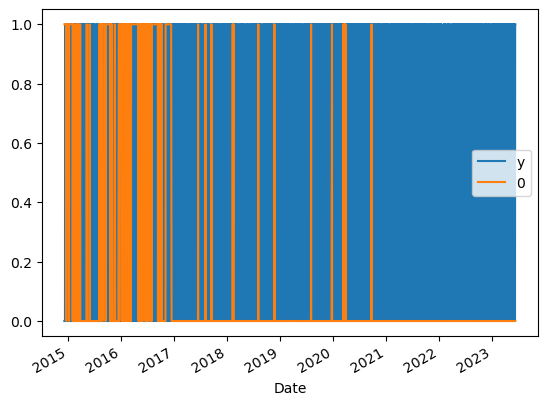

In [163]:
ys = pd.concat([y_test, pd.Series(y_pred, index=y_test.index)], axis=1)
ys.plot()

In [164]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["y"]

In [166]:
data["weekly_mean"] = weekly_mean['Close'] / data['Close']
data["quarterly_mean"] = quarterly_mean['Close'] / data['Close']
data["annual_mean"] = annual_mean['Close'] / data['Close']

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data['Close']
data["high_close_ratio"] = data["High"] / data['Close']
data["low_close_ratio"] = data["Low"] / data['Close']

In [167]:
data.head()

,Actual Close,y,Open,High,Low,Close,Volume,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,,,,
1980-12-15 00:00:00-05:00,0.094388,0.0,0.099584,0.100017,0.099584,0.099584,469033600.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.004348,1.0
1980-12-16 00:00:00-05:00,0.087461,0.0,0.094821,0.094821,0.094388,0.094388,175884800.0,NaN,NaN,NaN,NaN,NaN,NaN,1.004587,1.004587,1.0
1980-12-17 00:00:00-05:00,0.089625,1.0,0.087893,0.087893,0.087461,0.087461,105728000.0,NaN,NaN,NaN,NaN,NaN,NaN,1.004950,1.004950,1.0
1980-12-18 00:00:00-05:00,0.092224,1.0,0.089625,0.090058,0.089625,0.089625,86441600.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.004831,1.0
1980-12-19 00:00:00-05:00,0.097852,1.0,0.092224,0.092657,0.092224,0.092224,73449600.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.004694,1.0


In [168]:
data.dropna(inplace=True)
data.shape

(10348, 16)

In [169]:
# "weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "weekly_trend",
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "weekly_trend","open_close_ratio", "high_close_ratio", "low_close_ratio"]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(data, full_predictors, split=0.8)

scaler = StandardScaler()

X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_full_scaled = scaler.transform(X_test_full)

In [170]:
rf_model_full, y_pred_full = train_random_forest(X_train_full_scaled, X_test_full_scaled, y_train_full, y_test_full)

{'n_estimators': 150}
              precision    recall  f1-score   support

         0.0       0.48      0.61      0.54       985
         1.0       0.54      0.41      0.46      1085

    accuracy                           0.51      2070
   macro avg       0.51      0.51      0.50      2070
weighted avg       0.51      0.51      0.50      2070

[[601 384]
 [640 445]]
